In [ ]:
# use existing states made from several seeds to rerun autocorr, segmentation, and const/forget

In [1]:
# first, load the states from pkl
import pickle
# load states from several seeds
seedResStatesOriginal = []
seedResStatesShifted = []
original_seed_dir = '/home/ijackson/dynamics/sandbox/repos/NarrativeConn2Res/data/resStatesOriginal/'
shifted_seed_dir = '/home/ijackson/dynamics/sandbox/repos/NarrativeConn2Res/data/resStatesShifted/'

# collect all pkl files in each dir
import os
original_seed_files = os.listdir(original_seed_dir)
shifted_seed_files = os.listdir(shifted_seed_dir)

for file in original_seed_files:
    seedResStatesOriginal.append(pickle.load(open(original_seed_dir + file, 'rb')))

for file in shifted_seed_files:
    seedResStatesShifted.append(pickle.load(open(shifted_seed_dir + file, 'rb')))

In [10]:
seedResStatesOriginal[0]['DA'].shape

(682, 58)

In [62]:
# now look at autocorr by averaging across seeds
# each list is a seed, which has a dictionary of each network with a shape of (nTimepoints, nNodes)
import numpy as np

# autocorr for original states
meansAcrossSeedsOriginal = {key: None for key in seedResStatesOriginal[0].keys()}
for key in meansAcrossSeedsOriginal:
    # get the corrcoef
    corrCoefs = []
    for i, seed in enumerate(seedResStatesOriginal):
        corrCoefs.append(np.corrcoef(seed[key]))
    # average across seeds
    meansAcrossSeedsOriginal[key] = np.mean(corrCoefs, axis=0)


In [2]:
# now look at autocorr by averaging across seeds
# each list is a seed, which has a dictionary of each network with a shape of (nTimepoints, nNodes)
import numpy as np
from resUtils import nonzero_densities

# autocorr for original states
meansAcrossSeedsOriginal = {key: None for key in seedResStatesOriginal[0].keys()}

for key in meansAcrossSeedsOriginal.keys(): # for each network
    # get the corr coeff for each seed
    seedCorrCoeffs = []
    for seed in seedResStatesOriginal:
        seedCorrCoeffs.append(np.corrcoef(seed[key]))
    # average across seeds
    # normalize by network density
    density = nonzero_densities[key]
    meansAcrossSeedsOriginal[key] = np.mean(seedCorrCoeffs, axis=0) / density


# autocorr for original states
# meansAcrossSeedsOriginal2 = {key: None for key in seedResStatesOriginal[0].keys()}
# for key in meansAcrossSeedsOriginal2.keys(): # for each network
#     # get the avg activity across seeds
#     seedAvgActivity = []
#     for seed in seedResStatesOriginal:
#         seedAvgActivity.append(seed[key])
#     # average across seeds
#     avgd = np.mean(seedAvgActivity, axis=0)
#     # get the corr coeff for this avg activity
#     meansAcrossSeedsOriginal2[key] = np.corrcoef(avgd)

In [37]:
meansAcrossSeedsOriginal['DA'].shape

(682, 682)

/tmp/ipykernel_3201846/1985614015.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[1,0.1,1,1])


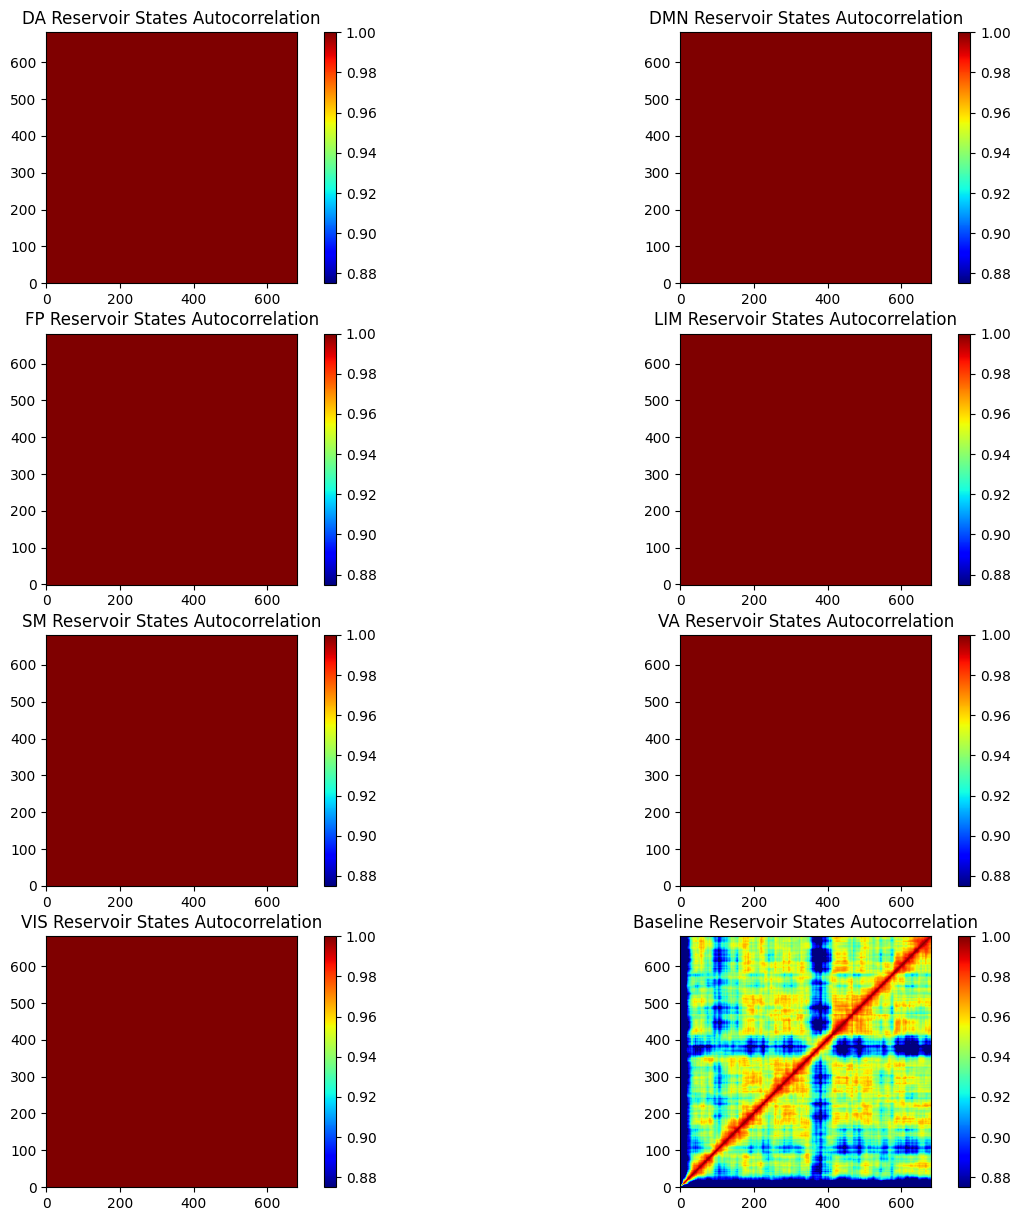

In [3]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,15))

for i, network in enumerate(seedResStatesOriginal[0].keys()):
    plt.subplot(4,2,i+1)
    plt.imshow(meansAcrossSeedsOriginal[network], cmap='jet', origin='lower', vmin=0.875, vmax=1)
    plt.colorbar()
    plt.title(network + ' Reservoir States Autocorrelation')

# fig.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=fig.get_axes(), orientation='horizontal', fraction = 0.05, pad = 0.1)
# cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=fig.get_axes(), orientation='horizontal', location='bottom', boundaries=[0.875, 1])
# cbar.boundaries = [0.875, 1]

plt.tight_layout(rect=[1,0.1,1,1])

# plt.savefig('reservoir-states-autocorr.png',dpi=600)

In [78]:
# ok now try segmentation again but with all seeds
from tqdm import tqdm
# segment the states with the HMM from Baldassano (2017)
import brainiak.eventseg.event
nEvents = 12
nTR = 682
bounds_per_seed = []
for seed in tqdm(seedResStatesOriginal):
    bounds_per_network = {network: None for network in seedResStatesOriginal[0].keys()}

    for network in tqdm(bounds_per_network):
        # 12 is the number of events for NTF, according to source github repo
        ev = brainiak.eventseg.event.EventSegment(nEvents)
        ev.fit(seed[network])
        bounds = np.where(np.diff(np.argmax(ev.segments_[0], axis=1)))[0]
        bounds_aug = np.concatenate(([0],bounds,[nTR]))
        bounds_per_network[network] = bounds_aug

    bounds_per_seed.append(bounds_per_network)

  0%|          | 0/100 [00:10<?, ?it/s]


KeyboardInterrupt: 

In [67]:
# now get the average bound size for each network
mean_bound_size = {network: None for network in seedResStatesOriginal[0].keys()}
for network in tqdm(mean_bound_size):
    mean_bound_size[network] = np.mean([bound_size[network] for bound_size in bounds_per_seed], axis=0)

100%|██████████| 8/8 [00:00<00:00, 2208.84it/s]


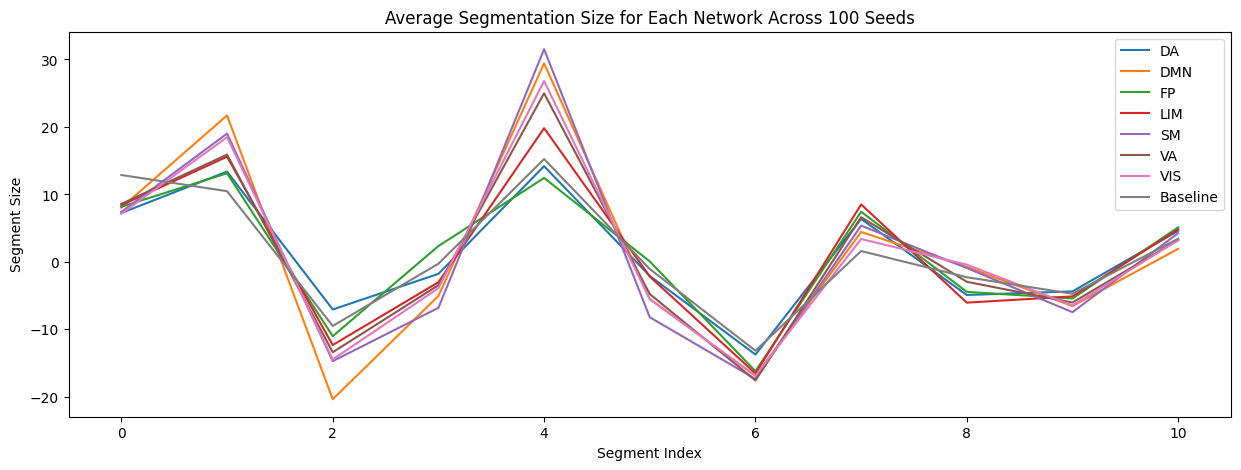

In [76]:
fig = plt.figure(figsize=(15, 5))

for network in mean_bound_size:
    plt.plot(np.diff(mean_bound_size[network]), label=network)
plt.title(f'Average Segmentation Size for Each Network Across {len(bounds_per_seed)} Seeds')
plt.xlabel('Segment Index')
plt.ylabel('Segment Size')
plt.legend()
plt.show()